# Project: Taxi Ride Duration

## 1. Problem statement

We will have to solve a real machine learning problem aimed at automating business processes. We will build a model that will predict the total duration of a taxi ride in New York.

Imagine you order a taxi from one point in New York to another, and the end point does not necessarily have to be within the city. How much will you have to pay for it? It is known that the cost of a taxi in the USA is calculated based on a fixed rate + a tariff cost, the amount of which depends on time and distance. Tariffs vary depending on the city.

In turn, the travel time depends on many factors such as where you are going from and to, what time of day you are making your trip, weather conditions, and so on.

Thus, if we develop an algorithm that can determine the duration of a trip, we will be able to predict its cost in the most trivial way, for example, simply multiplying the cost by a given tariff.
Taxi services store huge amounts of information about trips, including data such as the starting/final point of the route, the date of the trip and its duration. This data can be used to predict the duration of a trip automatically using artificial intelligence.

**Business task:** determine the characteristics and use them to predict the duration of a taxi trip.

**Technical task for you as a Data Science specialist:** build a machine learning model that will predict a numerical feature - taxi trip time - based on the proposed client characteristics. That is, solve the regression problem.

**Main goals of the project:**
1. Create a data set based on several sources of information
2. Design new features using Feature Engineering and identify the most significant ones when building a model
3. Explore the provided data and identify patterns
4. Build several models and select the best one for a given metric
5. Design a process for predicting the duration of a trip for new data

During the project, you will practice working with multiple data sources, feature generation, exploratory data analysis and visualization, feature selection, and of course, building machine learning models!

## 2. Getting to Know the Data, Basic Analysis, and Data Extension

Let's start our research by getting acquainted with the provided data. We will also load additional data sources and expand our initial dataset.

We import in advance the modules that we will need to solve the problem:

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys

from scipy import stats
from sklearn import cluster
from sklearn import ensemble
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import tree

sys.path.append('../../')


Let's read our file with the initial data:

In [251]:
taxi_data = pd.read_csv("../../data/Project5_train-taxi-ride.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


So, we have data on almost 1.5 million trips and 11 characteristics that describe each of the trips.

We have conditionally divided the features into several groups. We will further pay special attention to each of the groups.

**Client and fleet data:**
* id - unique trip identifier
* vendor_id - unique identifier of the vendor (taxi fleet) associated with the trip record

**Temporal characteristics:**
* pickup_datetime - date and time when the trip counter was turned on
* dropoff_datetime - date and time when the counter was turned off

**Geographical information:**
* pickup_longitude - longitude at which the counter was turned on
* pickup_latitude - latitude at which the counter was turned on
* dropoff_longitude - longitude at which the counter was turned off
* dropoff_latitude - latitude at which the counter was turned off

**Other features:**
* passenger_count - number of passengers in the vehicle (value entered by the driver)
* store_and_fwd_flag - flag that indicates whether the trip record was saved in the vehicle's memory before sending it to the vendor. Y - store and forward, N - do not store and do not forward the trip.

**Target attribute:**
* trip_duration - trip duration in seconds

To begin, we will conduct a basic analysis of how ready the data is for further pre-processing and analysis.

### Task 2.1
First, let's look at the time frame in which we work with the data.

Translate the pickup_datetime attribute into the datetime data type with the format year-month-day hour:minute:second.

Determine the time frame (excluding time) for which the data is presented.

In [252]:
taxi_data['pickup_dt'] = pd.to_datetime(taxi_data['pickup_datetime'])

print('Timeframe start:', taxi_data['pickup_dt'].min())
print('Timeframe end:', taxi_data['pickup_dt'].max())

Timeframe start: 2016-01-01 00:00:17
Timeframe end: 2016-06-30 23:59:39


### Task 2.2
Let's look at the empty values.
How many empty values ​​are present in the data (total for all columns of the table)?

In [253]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_dt             0
dtype: int64

### Task 2.3
Let's look at the statistical characteristics of some features.

a) How many unique taxi companies are present in the data?

b) What is the maximum number of passengers?

c) What is the mean and median trip duration? Give your answer in seconds and round to the nearest whole number.

d) What is the minimum and maximum trip time (in seconds)?

In [254]:
# a
print('Number of unique taxi companies:', taxi_data['vendor_id'].nunique())

# b
print('Maximum number of passengers:', taxi_data['passenger_count'].max())

# c
print('Mean trip duration:', taxi_data['trip_duration'].mean().round())
print('Median trip duration:', taxi_data['trip_duration'].median().round())

# d
print('Minimum trip duration:', taxi_data['trip_duration'].min())
print('Maximum trip duration:', taxi_data['trip_duration'].max())


Number of unique taxi companies: 2
Maximum number of passengers: 9
Mean trip duration: 959.0
Median trip duration: 662.0
Minimum trip duration: 1
Maximum trip duration: 3526282


Let's expand the original data set both with the help of external sources and with the help of manipulations of the features present in the data.

### Task 2.4
Implement the add_datetime_features() function that takes a table with trip data (DataFrame) as input and returns the same table with 3 columns added to it:
* pickup_date - the date the counter was turned on - the start of the trip (without time);
* pickup_hour - the hour of the day the counter was turned on;
* pickup_day_of_week - the ordinal number of the day of the week (number) on which the counter was turned on.

a) How many trips were made on Saturday?

b) How many trips are made on average per day? Round your answer to the nearest whole number

In [255]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_dt'].dt.date
    df['pickup_hour'] = df['pickup_dt'].dt.hour
    df['pickup_day_of_week'] = df['pickup_dt'].dt.dayofweek

    return df


taxi_data = add_datetime_features(taxi_data)

# a
print('Number of taxi rides on Saturdays:', taxi_data[taxi_data['pickup_day_of_week']==5].shape[0])

# b
print('Mean rides per day:', taxi_data.groupby('pickup_date')['id'].agg('count').mean().round())

Number of taxi rides on Saturdays: 220868
Mean rides per day: 8015.0


### Task 2.5
Implement the add_holiday_features() function that takes two tables as input:
* a table with trip data;
* a table with holiday data;

and returns an updated table with trip data with a pickup_holiday column added to it - a binary indicator of whether the trip started on a holiday or not (1 - yes, 0 - no).

What is the median duration of a taxi trip on holidays? Give your answer in seconds, rounded to the nearest whole number.

In [256]:
holiday_data = pd.read_csv('../../data/Project5_holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date
holiday_data = holiday_data.drop(['day', 'holiday'], axis=1)
holiday_data['pickup_holiday'] = 1


def add_holiday_features(df_trip, df_holiday):
    df_merged = df_trip.merge(right=df_holiday, how='left', left_on='pickup_date', right_on='date')
    df_merged = df_merged.drop('date', axis=1)
    df_merged['pickup_holiday'] = df_merged['pickup_holiday'].apply(lambda x: x if x == 1 else 0)
    return df_merged


taxi_data = add_holiday_features(taxi_data, holiday_data)

print('Median taxi trip duration on holidays:', taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median().round())

Median taxi trip duration on holidays: 585.0


### Task 2.6
Implement the add_osrm_features() function that takes two tables as input:
* table with trip data;
* table with data from OSRM;

and returns an updated table with trip data with 3 columns added to it:
* total_distance;
* total_travel_time;
* number_of_steps.

a) What is the difference (in seconds) between the median trip duration in the data and the median trip duration obtained from OSRM?

As a result of merging the tables, you should have gaps in the columns with information from the OSRM API. This is due to the fact that for some trips it was not possible to download data from the web source.

b) How many gaps are there in the columns with information from the OSRM API after merging the tables?

In [257]:
osrm_data = pd.read_csv('../../data/Project5_osrm_data_train_taxi.csv')
osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]


def add_osrm_features(df_trip, df_osrm):
    df_merged = df_trip.merge(right=df_osrm, how='left')
    
    return df_merged


taxi_data = add_osrm_features(taxi_data, osrm_data)

# a
median_trip_duration = taxi_data['trip_duration'].median()
median_duration_osrm = taxi_data['total_travel_time'].median()
print('Difference between real and osrm duration:', round(median_trip_duration - median_duration_osrm))

# b
print('The following number of records contain empty values:')
taxi_data.isnull().sum()

Difference between real and osrm duration: 372
The following number of records contain empty values:


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_dt             0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [258]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # earth radius in kilimeters
    EARTH_RADIUS = 6371 
    # calculate the shortest distance h using the Haversine formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_angle_direction(lat1, lng1, lat2, lng2):
    # convert angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # calculate the angle of the direction of movement alpha using the bearing angle formula
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Task 2.7.
Implement the add_geographical_features() function that takes a table of trip data as input and returns an updated table with 2 columns added to it:
* haversine_distance - the Haversine distance between the point where the meter was turned on and the point where the meter was turned off;
* direction - the direction of travel from the point where the meter was turned on to the point where the meter was turned off.

What is the median Haversine distance of trips (in kilometers)? Round your answer to hundredths.

In [259]:
def add_geographical_features(df_trip):
    df_trip['haversine_distance'] = df_trip.apply(lambda x: get_haversine_distance(
        x['pickup_latitude'], x['pickup_longitude'],
        x['dropoff_latitude'], x['dropoff_longitude']
    ), axis=1)
    df_trip['direction'] = df_trip.apply(lambda x: get_angle_direction(
        x['pickup_latitude'], x['pickup_longitude'],
        x['dropoff_latitude'], x['dropoff_longitude']
    ), axis=1)
    
    return df_trip


taxi_data = add_geographical_features(taxi_data)

print('Median Haversine distance:', taxi_data['haversine_distance'].median().round(2))

Median Haversine distance: 2.09


### Task 2.8.
Implement the add_cluster_features() function that takes a table of trip data and a trained clustering algorithm as input. The function should return an updated table with the geo_cluster column added to it - the geographic cluster to which the trip belongs.

How many trips are contained in the smallest geographic cluster?

In [260]:
def add_cluster_features(df_trip, kmeans):
    df_trip['geo_cluster'] = kmeans.predict(df_trip[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
    
    return df_trip


# train clusterization model
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(taxi_data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

taxi_data = add_cluster_features(taxi_data, kmeans)
print('Number of trips in the smallest geographic cluster:', taxi_data['geo_cluster'].value_counts().values[-1])

Number of trips in the smallest geographic cluster: 2


### Task 2.9.
Implement the add_weather_features() function that takes two tables as input:
* a table with trip data;
* a table with hourly weather data;

and returns an updated table with trip data with 5 columns added to it:
* temperature;
* visibility;
* wind speed;
* precip;
* events.

a) How many trips were made in snowy weather?

As a result of the merge, you should get records for which there will be empty values in the temperature, visibility, wind speed, precip, and events columns. This is due to the fact that the table with weather data is missing measurements for some points in time at which the trip counter was turned on.

b) What percent of the total number of observations in the table with trip data are empty values in the weather columns? Give your answer to the hundredths of a percent.

In [261]:
def add_weather_features(df_trip, df_weather):
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    df_weather['date'] = df_weather['time'].dt.date
    df_weather['hour'] = df_weather['time'].dt.hour
    df_weather['events'] = df_weather['events'].apply(lambda x: 'None' if pd.isnull(x) else x)

    df_weather = df_weather.drop(['time', 'windchill', 'heat index', 
                                   'humidity', 'pressure', 'dew Point', 
                                   'wind dir', 'gust speed', 'conditions'],
                                 axis=1)

    df_trip = pd.merge(left=df_trip, right=df_weather, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'])
    df_trip = df_trip.drop(['date', 'hour'], axis=1)
    
    return df_trip


weather_data = pd.read_csv('../../data/Project5_weather_data.csv')

taxi_data = add_weather_features(taxi_data, weather_data)

# a
print('Number of taxi rides in different weather conditions:', taxi_data['events'].value_counts())

# b
empty_weather_count = taxi_data.isnull().sum().values[-1]
empty_weather_ratio = 100 * empty_weather_count / taxi_data.shape[0]
print(f'Percent of empty weather values: {empty_weather_ratio:.2f}')

Number of taxi rides in different weather conditions: events
None    1375185
Rain      58300
Snow      13126
Fog           1
Name: count, dtype: int64
Percent of empty weather values: 0.82


### Task 2.10.
Implement the fill_null_weather_data() function, which takes a table with trip data as input. The function should fill in missing values ​​in the columns.

Fill in the empty values in the columns with weather conditions - temperature, visibility, wind speed, precip with the median value of temperature, visibility, wind speed and precip depending on the start date of the trip. To do this, group the data by the pickup_date column and calculate the median in each group, then fill in the emtpy values using a combination of the transform() and fillna() methods.

Fill in the empty values in the events column with the string 'None' - a symbol for the absence of weather phenomena (snow/rain/fog).

Fill in the gaps in the columns with information from the OSRM API - total_distance, total_travel_time and number_of_steps with the median value by column.

What is the median in the temperature column after filling in the blanks? Round your answer to tenths.

In [262]:
def fill_null_weather_data(df_trip):
    df_trip['temperature'] = df_trip['temperature'].fillna(df_trip.groupby('pickup_date')['temperature'].transform('median'))
    df_trip['visibility'] = df_trip['visibility'].fillna(df_trip.groupby('pickup_date')['visibility'].transform('median'))
    df_trip['wind speed'] = df_trip['wind speed'].fillna(df_trip.groupby('pickup_date')['wind speed'].transform('median'))
    df_trip['precip'] = df_trip['precip'].fillna(df_trip.groupby('pickup_date')['precip'].transform('median'))
    df_trip['events'] = df_trip['events'].fillna('None')
    
    return df_trip


taxi_data = fill_null_weather_data(taxi_data)
taxi_data['total_distance'] = taxi_data['total_distance'].fillna(taxi_data['total_distance'].median())
taxi_data['total_travel_time'] = taxi_data['total_travel_time'].fillna(taxi_data['total_travel_time'].median())
taxi_data['number_of_steps'] = taxi_data['number_of_steps'].fillna(taxi_data['number_of_steps'].median())

print('Median temperature value:', taxi_data['temperature'].median().round(1))

Median temperature value: 11.1


In conclusion of the first part, let's find obvious outliers in the target variable - trip duration.

The easiest way is to find trips that are too long. Let's agree that outliers will be trips that last longer than 24 hours.

It's a little more difficult to analyze trips that are too short. Because there are real short-distance trips, trips that were canceled a second after the meter started, and "teleportations" - moving for long distances in a matter of seconds.

Let's agree that we will consider only the last group as outliers. How can we detect them in the simplest way?

We can use information about the shortest distance that a taxi travels. Calculate the average speed of a car on the shortest route as follows:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
If we plot a scatter plot of the average speed of cars, we will see the following picture:

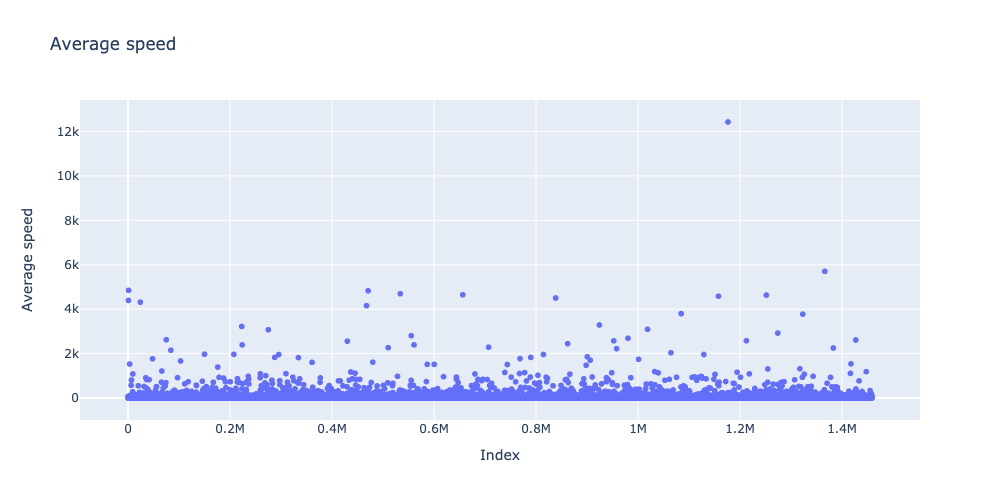

In [263]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6

fix = px.scatter(
    avg_speed,
    width=1000,
    height=500,
    title='Average speed'
).update_layout(
    showlegend=False,
    yaxis_title='Average speed',
    xaxis_title='Index'
)
fix.show('png')

We see that we have “teleportation trips” for which the average speed is over 1000 km/h. There is even one whose average speed was over 12,000 km/h!

Let’s agree that the maximum average speed that taxi drivers can reach is 300 km/h.

### Task 2.11.
Find trips that last longer than 24 hours. And remove them from the dataset.

a) How many trip duration outliers did you find?

Find trips that have an average speed above 300 km/h on the shortest route and remove them from the data.

b) How many speed outliers did you find?

In [264]:
# a 
outliers_24h = taxi_data[taxi_data['trip_duration']>60*60*24]
print('Trips that last longer than 24 hours:', outliers_24h.shape[0])
taxi_data = taxi_data.drop(outliers_24h.index, axis=0)

# b
outliers_300kmh = taxi_data[taxi_data['total_distance']/taxi_data['trip_duration']*3.6>300]
print(
    'Trips that have average speed above 300 km/h:', 
    outliers_300kmh.shape[0]
)
taxi_data = taxi_data.drop(outliers_300kmh.index, axis=0)

Trips that last longer than 24 hours: 4
Trips that have average speed above 300 km/h: 407


## 3. Exploratory Data Analysis (EDA)

In this part of our project, we will:
* Explore the generated data set;
* Try to find patterns that allow us to formulate preliminary hypotheses regarding which factors are decisive in determining the duration of the trip;
* Supplement our analysis with visualizations illustrating the research.

Let's start with the target feature. Looking ahead, we will say that the main metric of the quality of the solution to the problem will be RMSLE - Root Mean Squared Log Error, which is calculated based on the target variable on a logarithmic scale. In this case, it is advisable to immediately logarithmize the trip duration feature and consider the logarithm as the target feature during the analysis:
$$trip\_duration\_log = log(trip\_duration+1),$$
where the symbol log means the natural logarithm.

In [265]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Task 3.1.
Plot a histogram and a boxplot of trip duration on a logarithmic scale (trip_duration_log).

Based on the visualization, make a guess whether the resulting distribution is normal?
Test your hypothesis using the D'Agostino test at a significance level of $\alpha=0.05$.

a) What is the calculated p-value? Round the answer to hundredths.

b) Is the distribution of trip duration on a logarithmic scale normal?

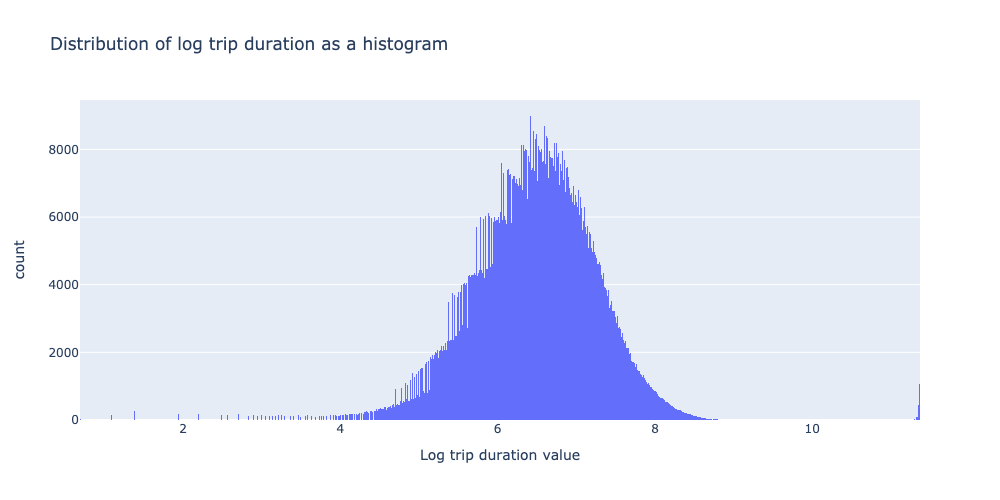

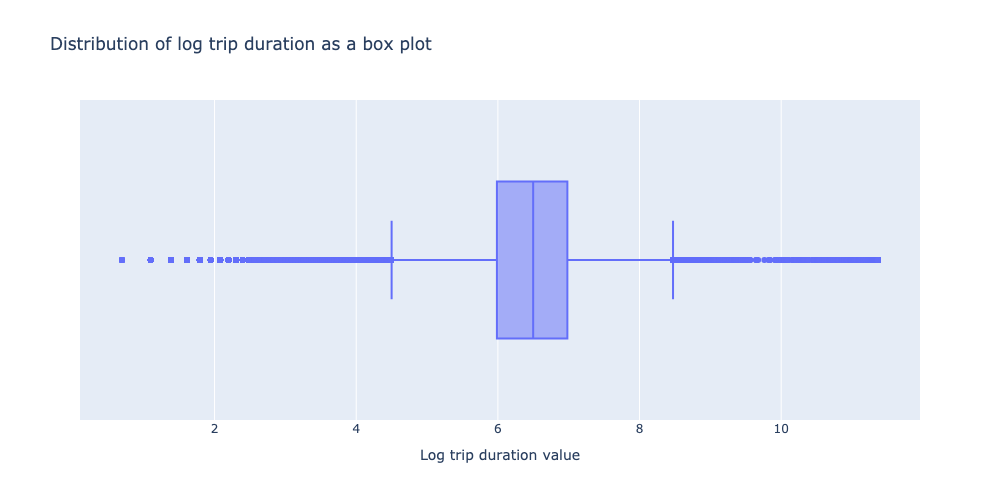

p-value=0.000 is less than or equal to the defined statistical significance α=0.05. Data does not have normal distribution.


In [266]:
fig = px.histogram(
    taxi_data, 
    x='trip_duration_log',
    width=1000,
    height=500,
    title='Distribution of log trip duration as a histogram'
).update_layout(
    xaxis_title='Log trip duration value'
)
fig.show('png')

fig = px.box(
    taxi_data, 
    x='trip_duration_log',
    width=1000,
    height=500,
    title='Distribution of log trip duration as a box plot'
).update_layout(
    xaxis_title='Log trip duration value'
)
fig.show('png')

# a
_, p = stats.normaltest(taxi_data['trip_duration_log'])
alpha = 0.05

# b
if p <= alpha:
    print(
        f'''p-value={p:.3f} is less than or equal to the defined statistical significance α={alpha:.2f}. Data does not have normal distribution.'''
    )
else:
    print(
        f'''p-value={p:.3f} is greater than the defined statistical significance α={alpha:.2f}. Data has normal distribution.'''
    )        

### Task 3.2.
Build a visualization that will allow you to compare the distribution of trip duration on a logarithmic scale (trip_duration_log) depending on the taxi company (vendor_id).

Compare the two distributions with each other.

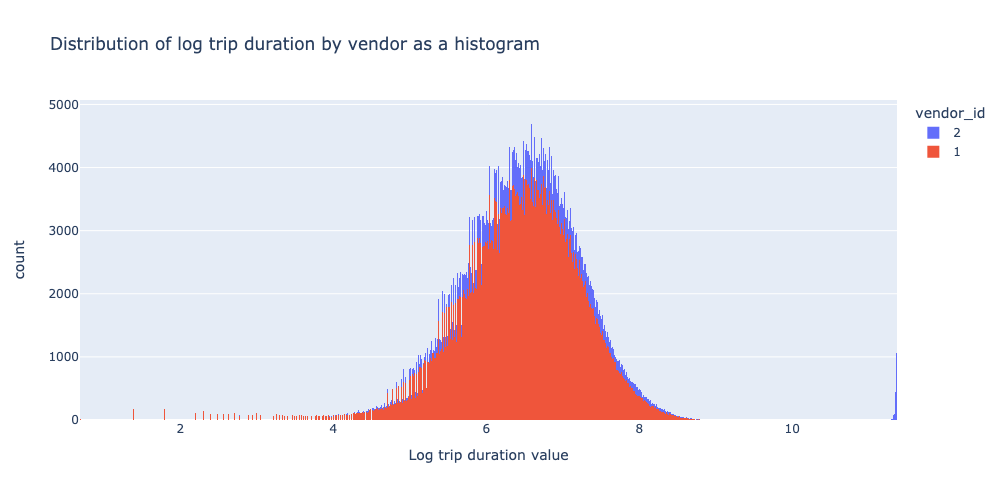

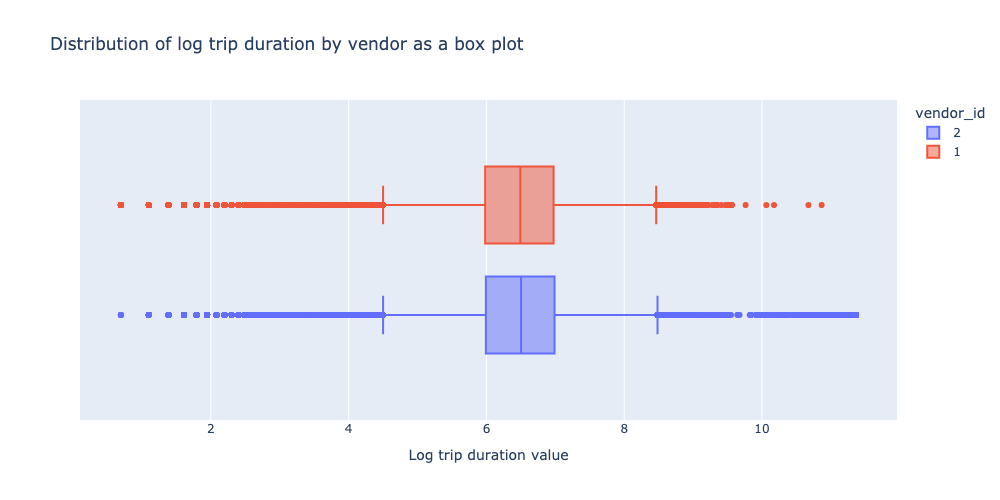

In [267]:
fig = px.histogram(
    taxi_data, 
    x='trip_duration_log',
    color='vendor_id',
    width=1000,
    height=500,
    title='Distribution of log trip duration by vendor as a histogram'
).update_layout(
    barmode='overlay',
    xaxis_title='Log trip duration value'
)
fig.show('png')

fig = px.box(
    taxi_data, 
    x='trip_duration_log',
    color='vendor_id',
    width=1000,
    height=500,
    title='Distribution of log trip duration by vendor as a box plot'
).update_layout(
    xaxis_title='Log trip duration value'
)
fig.show('png')


> **Conclusion:**
> 
> There is no significant visual difference between the rides conducted by different vendors.

### Task 3.3.
Build a visualization that will allow you to compare the distribution of trip duration on a logarithmic scale (trip_duration_log) depending on the flag of sending a message to the supplier (store_and_fwd_flag).

Compare the two distributions with each other.

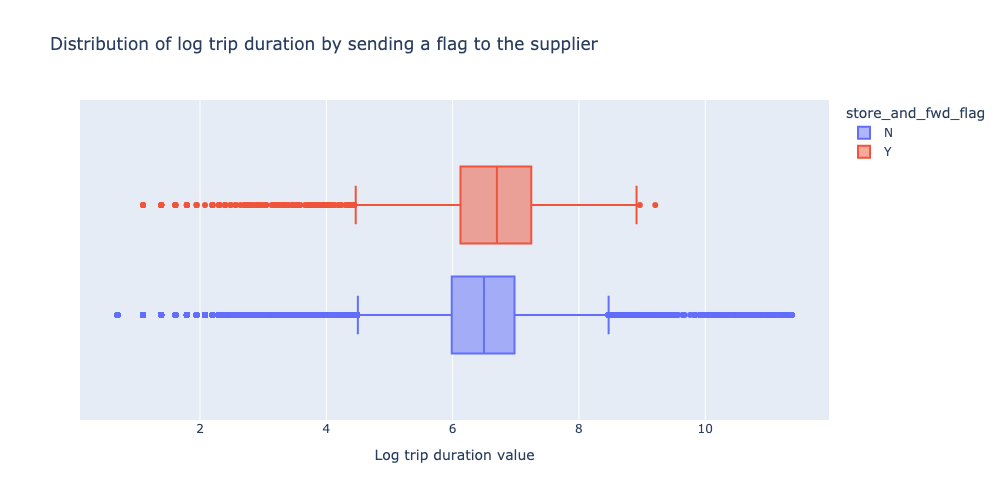

In [268]:
fig = px.box(
    taxi_data, 
    x='trip_duration_log',
    color='store_and_fwd_flag',
    width=1000,
    height=500,
    title='Distribution of log trip duration by sending a flag to the supplier'
).update_layout(
    xaxis_title='Log trip duration value'
)
fig.show('png')

> **Conclusion:**
> 
> There is a significant visual difference based on whether the message has been sent to the supplier. There is a tred that the messages have been sent for the longer trips.

### Task 3.4.
Build two visualizations:
* Distribution of the number of trips depending on the hour of the day;
* Dependence of the median trip duration on the hour of the day.

Based on the constructed graphs, answer the following questions:

a) At what time of day are taxis ordered the least often?

b) At what time of day is the peak of the median trip duration observed?

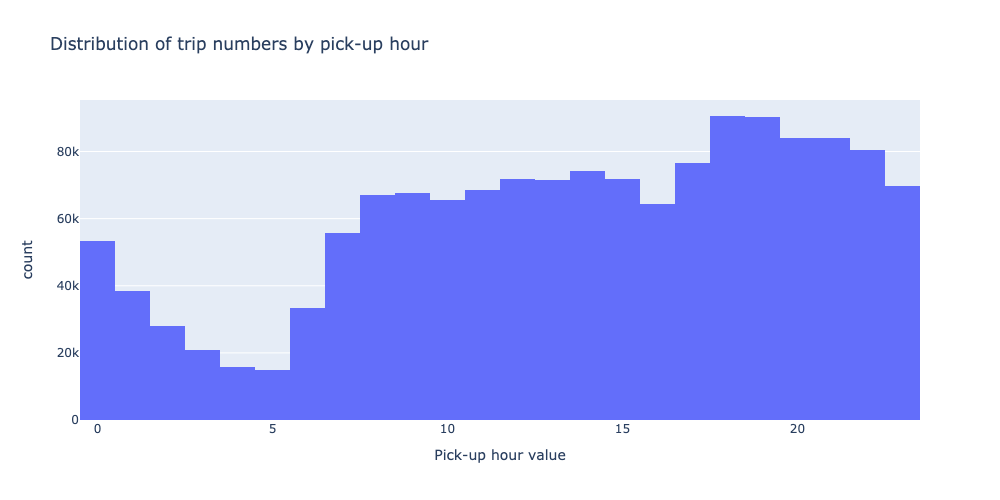

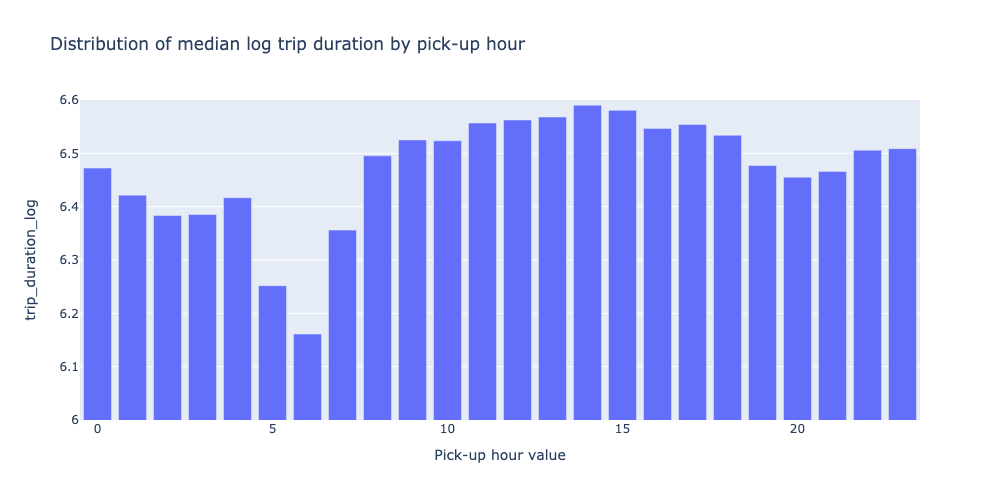

In [269]:
fig = px.histogram(
    taxi_data, 
    x='pickup_hour',
    width=1000,
    height=500,
    title='Distribution of trip numbers by pick-up hour'
).update_layout(
    xaxis_title='Pick-up hour value'
)
fig.show('png')

median_trip_duration_by_hour = taxi_data.groupby('pickup_hour')['trip_duration_log'].agg('median')
fig = px.bar(
    median_trip_duration_by_hour, 
    x=median_trip_duration_by_hour.index,
    y='trip_duration_log',
    width=1000,
    height=500,
    title='Distribution of median log trip duration by pick-up hour'
).update_layout(
    xaxis_title='Pick-up hour value',
    yaxis_range=[6,6.6]
)
fig.show('png')


> **Conclusion:**
> 
> \# a
> The taxies are least frequently ordered at 5 am.

> \# b
> Peak of the median log trip duration is observed at 2 pm.


### Task 3.5.
Build two visualizations:
* Distribution of the number of trips depending on the day of the week;
* Dependence of the median trip duration on the day of the week.

Based on the constructed graphs, answer the following questions:
a) On which day of the week are the most trips made?
b) On which day of the week is the median trip duration the shortest?

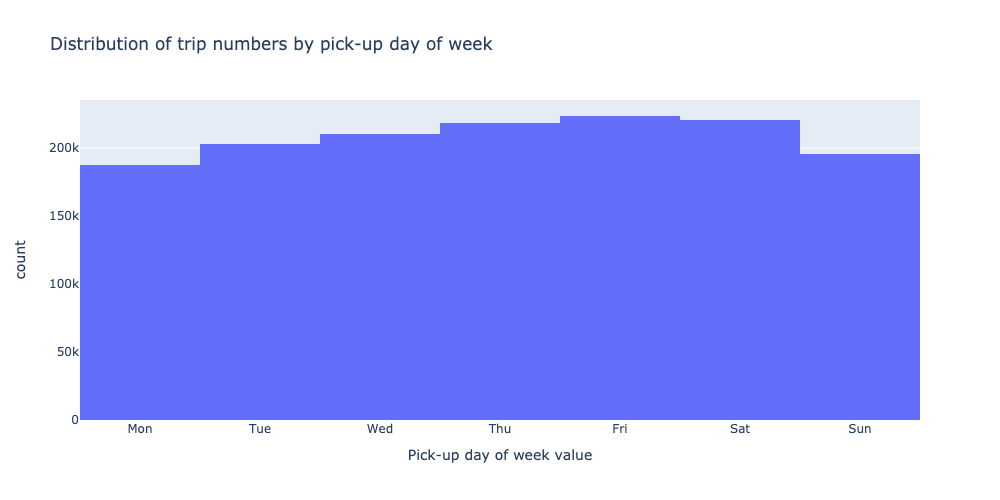

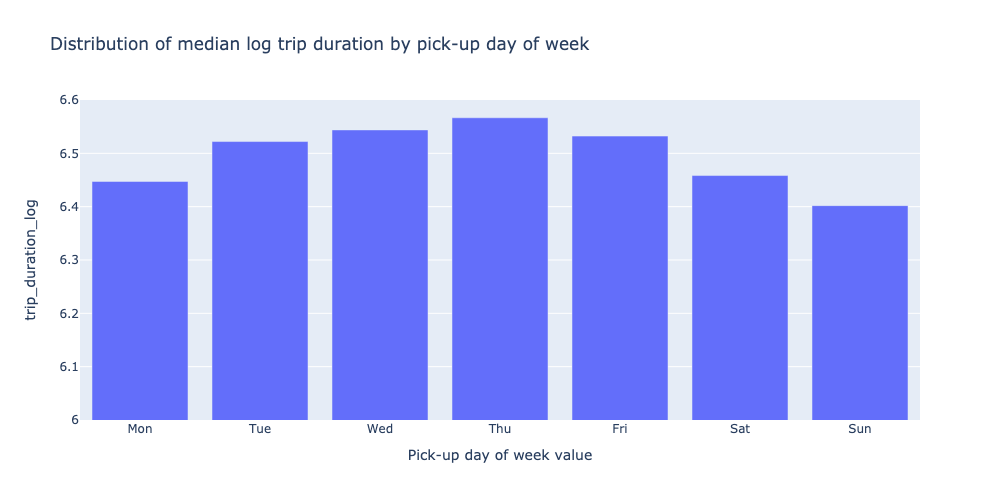

In [270]:
fig = px.histogram(
    taxi_data, 
    x='pickup_day_of_week',
    width=1000,
    height=500,
    title='Distribution of trip numbers by pick-up day of week'
).update_layout(
    xaxis_title='Pick-up day of week value',
    xaxis_tickvals=[*range(0, 7)],
    xaxis_ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
fig.show('png')

median_trip_duration_by_hour = taxi_data.groupby('pickup_day_of_week')['trip_duration_log'].agg('median')
fig = px.bar(
    median_trip_duration_by_hour, 
    x=median_trip_duration_by_hour.index,
    y='trip_duration_log',
    width=1000,
    height=500,
    title='Distribution of median log trip duration by pick-up day of week'
).update_layout(
    xaxis_title='Pick-up day of week value',
    yaxis_range=[6,6.6],
    xaxis_tickvals=[*range(0, 7)],
    xaxis_ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
fig.show('png')

> **Conclusion:**
> 
> \# a
> The taxies are most frequently ordered on Fridays.

> \# b
> The lowers median log trip duration is observed on Sundays.


### Task 3.6.
Let's look at both time characteristics simultaneously.

Build a pivot table with hours (pickup_hour) in the rows, days of the week (pickup_day_of_week) in the columns, and median trip duration (trip_duration) in the cells.

Visualize the resulting pivot table using a heat map (recommended palette - coolwarm).

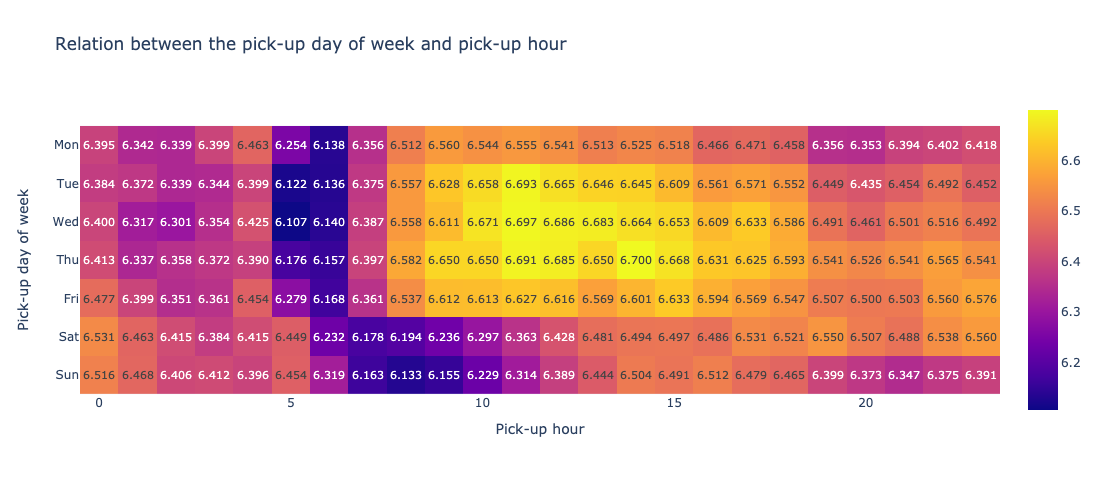

In [271]:
pivot_day_hour = taxi_data.pivot_table(
    values='trip_duration_log', 
    index='pickup_day_of_week', 
    columns='pickup_hour', 
    aggfunc='median'
)

fig = px.imshow(
    pivot_day_hour,
    width=1100,
    height=500,
    text_auto='.3f',
    title='Relation between the pick-up day of week and pick-up hour'
).update_layout(
    xaxis_title='Pick-up hour',
    yaxis_title='Pick-up day of week',
    yaxis_tickvals=[*range(0, 7)],
    yaxis_ticktext=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
fig.show('png')

### Task 3.7.
Build two scatter diagrams:
* the first should illustrate the geographic location of the pickup points (pickup_longitude, pickup_latitude)
* the second should illustrate the geographic location of the dropoff points (dropoff_longitude, dropoff_latitude).

To do this, plot the latitude (longitude) on the abscissa axis of the diagrams, and the longitude (latitude) on the ordinate axis.

Include in the visualization only those points that are within New York City - add the following constraints to the boundaries of the abscissa and ordinate axes:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Add coloring to the diagrams based on the ten geographic clusters (geo_cluster) that we generated earlier.

**Recommendation:** For clarity, reduce the size of the dots in the scatter plot.

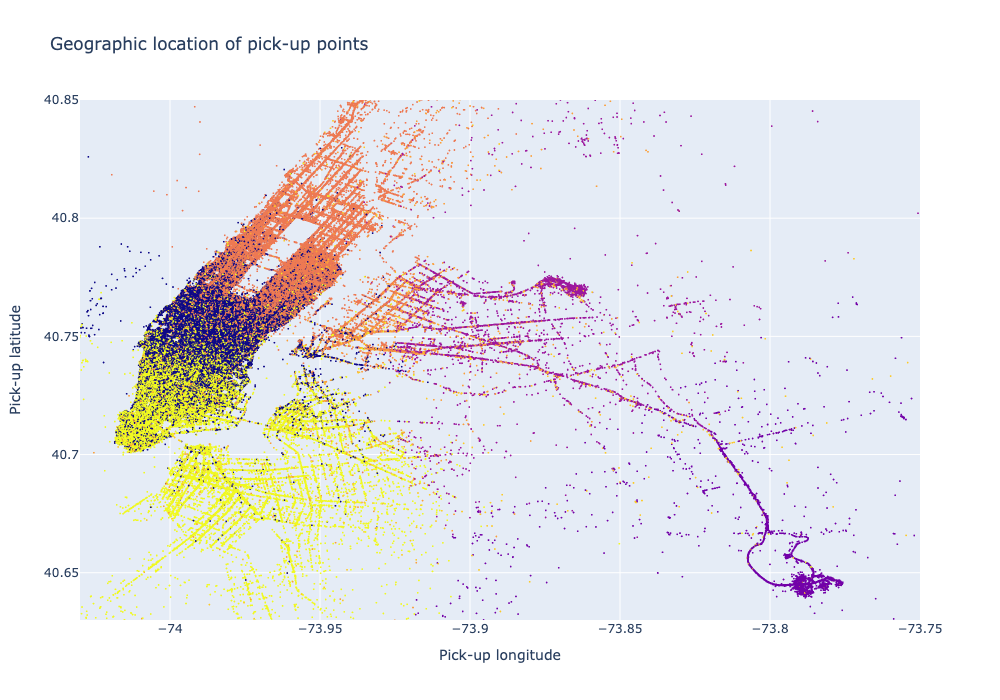

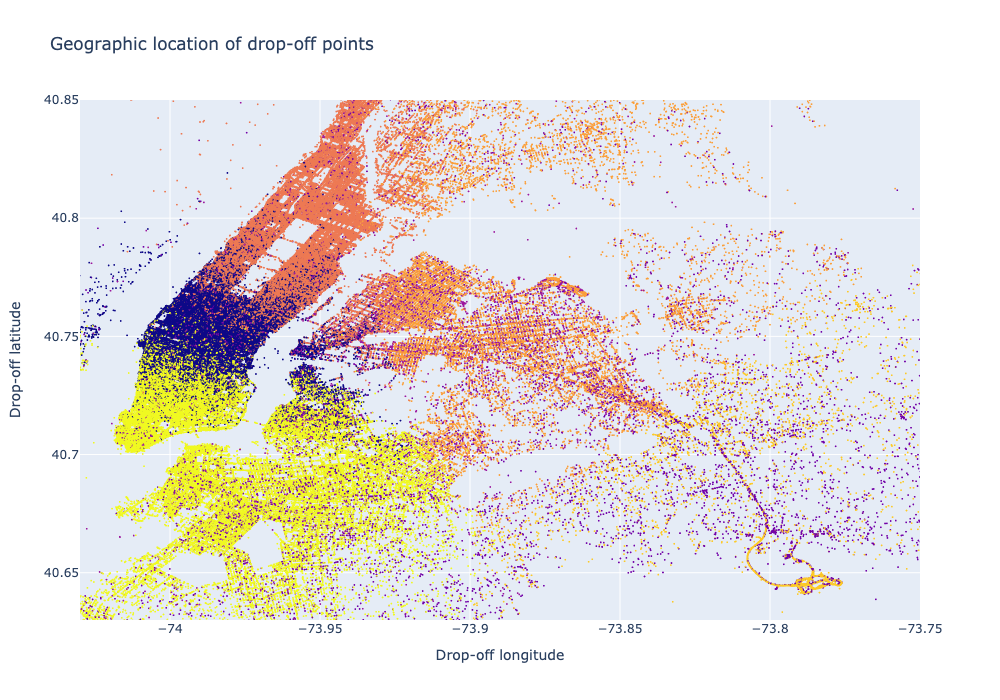

In [272]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig = px.scatter(
    taxi_data,
    x='pickup_longitude',
    y='pickup_latitude',
    color='geo_cluster',
    width=1000,
    height=700,
    title='Geographic location of pick-up points'
).update_layout(
    xaxis_title='Pick-up longitude',
    yaxis_title='Pick-up latitude',
    xaxis_range=city_long_border,
    yaxis_range=city_lat_border,
    coloraxis_showscale=False
).update_traces(
    marker_size=2
)
fig.show('png')

fig = px.scatter(
    taxi_data,
    x='dropoff_longitude',
    y='dropoff_latitude',
    color='geo_cluster',
    width=1000,
    height=700,
    title='Geographic location of drop-off points'
).update_layout(
    xaxis_title='Drop-off longitude',
    yaxis_title='Drop-off latitude',
    xaxis_range=city_long_border,
    yaxis_range=city_lat_border,
    coloraxis_showscale=False
).update_traces(
    marker_size=2
)
fig.show('png')

## 4. Selection and transformation of features

There are still a few steps to take before we can start building the model.
* It should be remembered that many machine learning algorithms cannot process categorical features in their usual form. Therefore, we need to encode them;
* We need to select the features that we will use to train the model;
* It is necessary to scale and transform some features in order to improve the convergence of models based on numerical methods.

In [273]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 28)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_dt', 'pickup_date', 'pickup_hour',
       'pickup_day_of_week', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'geo_cluster', 'temperature', 'visibility', 'wind speed',
       'precip', 'events', 'trip_duration_log'],
      dtype='object')


In [274]:
# Drop redundant column
taxi_data = taxi_data.drop('pickup_dt', axis=1)

For ease of use, let's make a copy of the original table with trips:

In [275]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Task 4.1.
Let's take care of the obvious uninformative and redundant features right away.

a) Which of the features is unique for each trip and does not provide useful information in determining its duration?

b) A data leak is a situation in which the data used to train a model contains direct or indirect information about the target variable, but this data is not available in the real world.

c) Think about which of the features in the training data set creates a data leak?

d) Exclude the features selected in points a) and c) from the original data table. How many columns are left in your table?

In [276]:
# a - id is unique for each trip and does not provide any useful information

# c - dropoff_datetime is a data leak

# d
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Number of columns: ', train_data.shape[1])

Number of columns:  25


Previously we extracted all the information we needed from the trip start date, now we can get rid of these features, as we will no longer need them:

In [277]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Number of columns: ', train_data.shape[1])

Number of columns:  23


### Task 4.2.

Encode the vendor_id feature in the train_data table so that it equals 0 if the taxi company ID equals 1, and 1 otherwise.

Encode the store_and_fwd_flag feature in the train_data table so that it equals 0 if the flag is set to 'N', and 1 otherwise.

a) Calculate the average for the encoded vendor_id column. Give your answer accurate to hundredths.

b) Calculate the average for the encoded store_and_fwd_flag column. Give your answer accurate to thousandths.

In [278]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# a
print('Mean vendor_id value:', train_data['vendor_id'].mean().round(2))

# b
print('Mean store_and_fwd_flag value:', train_data['store_and_fwd_flag'].mean().round(3))

Mean vendor_id value: 0.53
Mean store_and_fwd_flag value: 0.006


### Task 4.3.
Create a data_onehot table from the one-hot encoded features pickup_day_of_week, geo_cluster, and events in the train_data table using OneHotEncoder from the sklearn library. Set the drop parameter to 'first' to remove the first binary column, thereby not creating unnecessary features.

Set the handle_unknown parameter to 'ignore'. This will allow the code to work without errors if the test sample contains values ​​that are not present in the training sample.

As a result of OneHotEncoder, you will get an unnamed numpy array, which we will need to convert back to a DataFrame for more convenient work in the future. To get the names of the encoded columns, the OneHotEncoder object has a special method get_feature_names_out().

As a result of completing the task, you should have a DataFrame `data_onehot`, which contains the encoded categorical features pickup_day_of_week, geo_cluster and events.

How many binary columns were you able to generate using one-hot encoding?

In [279]:
categorical_columns = ['pickup_day_of_week', 'geo_cluster', 'events']
ohe = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')
data_onehot = ohe.fit_transform(train_data[categorical_columns]).toarray()
oh_columns = ohe.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=oh_columns)

print('Number of columns: ', train_data.shape[1])

Number of columns:  23


Let's add the resulting table with encoded features:

In [280]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(categorical_columns, axis=1), data_onehot], 
    axis=1
)
print('Number of columns: ', train_data.shape[1])

Number of columns:  38


Now that the categorical features have been preprocessed, we form the observation matrix X, the target variable vector y, and its logarithm y_log. The observation matrix will include all columns from the trip table except for the target feature trip_duration and its logarithmized version trip_duration_log:

In [281]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

We will train all our models on the logarithmic version of y_log.

The selected validation type is hold-out. We will split the sample into training and validation in the ratio 67/33:

In [282]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

At this point, we have quite a lot of features: most likely, not all of them will be important. Let's keep only those that are most closely related to the target variable and will definitely contribute to improving the quality of the model.

### Task 4.4.
Using SelectKBest, select 25 features that are best suited for predicting the target variable on a logarithmic scale. Perform the selection on the training set using the score_func = f_regression parameter.

In [283]:
skb = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)
skb.fit_transform(X_train, y_train_log)
best_features = list(skb.get_feature_names_out())
print('25 most relevant features:', best_features)

X_train = X_train[best_features]
X_valid = X_valid[best_features]

25 most relevant features: ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'temperature', 'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8']


Since we will use various models, including those that contain numerical optimization methods, let's take care of scaling the factors in advance.

### Task 4.5.
Normalize the predictors in the training and validation sets using MinMaxScaler from the sklearn library. Remember that the normalizer is trained on the training set, and the transformation is performed on the training and validation sets!

Calculate the arithmetic mean for the first predictor (i.e. for the first column of the matrix) from the validation set. Round the answer to hundredths.

In [284]:
mms = preprocessing.MinMaxScaler()
mms.fit(X_train)
X_train_scaled = mms.transform(X_train)
X_valid_scaled = mms.transform(X_valid)

print('Mean for the first predictor:', X_valid_scaled[:, 0].mean().round(2))

Mean for the first predictor: 0.54


## 5. Solving a Regression Problem: Linear Regression and Decision Trees

Let's define a metric by which we will measure the quality of our models. We will follow the canons of the original Kaggle competition and use RMSLE (Root Mean Squared Log Error) as a metric, which is calculated as:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
where:
* $y_i$ is the true duration of the i-th taxi trip (trip_duration)
* $\hat{y_i}$ is the duration of the i-th taxi trip predicted by the model

Note that we have already taken the logarithm of the target feature in advance, so it will be enough for us to calculate the RMSE metric for a model trained to predict the duration of a taxi trip on a logarithmic scale:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$

### Task 5.1.
Build a linear regression model on the training sample (factors must be normalized, use the target variable on a logarithmic scale). Leave all parameters by default.

For the resulting model, calculate the RMSLE metric on the training and validation samples. Round the answer to hundredths.

In [285]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train_log)
y_pred_train = lr.predict(X_train_scaled)
y_pred_valid = lr.predict(X_valid_scaled)

print('RMSE on training samples', metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2))
print('RMSE on validation samples', metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2))

RMSE on training samples 0.54
RMSE on validation samples 0.54


### Task 5.2.
Generate second-degree polynomial features using PolynomialFeatures from the sklearn library. Set the include_bias parameter to False.

Build a second-degree polynomial regression model on the training set (factors must be normalized, use the target variable on a logarithmic scale). Leave all parameters by default.

a) Calculate the RMSLE metric for the resulting model on the training and validation sets. Round the answer to hundredths.

b) Does your model show signs of overfitting?

In [286]:
pf = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
pf.fit(X_train_scaled)
X_train_scaled_poly = pf.transform(X_train_scaled)
X_valid_scaled_poly = pf.transform(X_valid_scaled)

lr = linear_model.LinearRegression()
lr.fit(X_train_scaled_poly, y_train_log)
y_pred_train = lr.predict(X_train_scaled_poly)
y_pred_valid = lr.predict(X_valid_scaled_poly)

# a
print('RMSE on training samples', metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2))
print('RMSE on validation samples', metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2))

RMSE on training samples 0.47
RMSE on validation samples 0.69


> **Conclusion:**
> 
> \# b
> There is an overfitting in the model above, since the result on the train dataset is significantly better than on the validation dataset.

### Task 5.3.
Build a second-degree polynomial regression model with L2-regularization (Tikhonov regularization) on the training sample (factors should be normalized, use the target variable on a logarithmic scale). Set the regularization coefficient $\alpha$ to 1, leave the other parameters by default.

For the resulting model, calculate the RMSLE metric on the training and validation samples. Round the answer to hundredths.

In [287]:
l2 = linear_model.Ridge(alpha=1)
l2.fit(X_train_scaled_poly, y_train_log)

y_pred_train = l2.predict(X_train_scaled_poly)
y_pred_valid = l2.predict(X_valid_scaled_poly)

print('RMSE on training samples', metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2))
print('RMSE on validation samples', metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2))

RMSE on training samples 0.48
RMSE on validation samples 0.48


### Task 5.4.
Build a decision tree model (DecisionTreeRegressor) on the training set (factors should be normalized, use the target variable on a logarithmic scale). Leave all parameters by default.

a) Calculate the RMSLE metric for the resulting model on the training and validation sets. Round the answer to hundredths.

b) Does your model show signs of overfitting?

In [288]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train_log)

y_pred_train = dtr.predict(X_train_scaled)
y_pred_valid = dtr.predict(X_valid_scaled)

# a
print('RMSE on training samples', metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2))
print('RMSE on validation samples', metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2))

RMSE on training samples 0.0
RMSE on validation samples 0.57


> **Conclusion:**
> 
> \# b
> There is an overfitting in the model above, since the result on the train dataset is significantly better than on the validation dataset.

### Task 5.5.
Go through all possible options for the decision tree depth in the range from 7 to 20:

max_depths = range(7, 20)

Set the random_state parameter to 42.

Plot linear graphs of the change in the RMSE metric on the training and validation samples depending on the value of the decision tree depth parameter.

a) Find the optimal value of the maximum tree depth for which the minimum RMSLE value will be observed on the training sample, but overfitting will not yet be observed (the validation curve has not yet begun to increase).

b) What is the value of the RMSLE metrics on the training and validation samples for the decision tree with the selected optimal depth? Round the answer to hundredths.

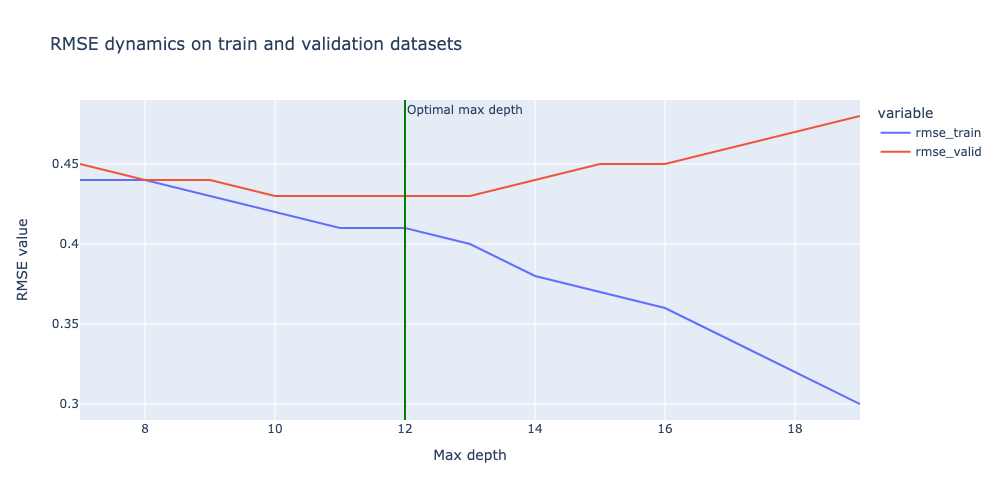

In [289]:
max_depths = range(7, 20)
random_state = 42
observations = []

for md in max_depths:
    dtr = tree.DecisionTreeRegressor(max_depth=md, random_state=42)
    dtr.fit(X_train_scaled, y_train_log)

    y_pred_train = dtr.predict(X_train_scaled)
    y_pred_valid = dtr.predict(X_valid_scaled)

    rmse_train = metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2)
    rmse_valid = metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2)
    observations.append([md, rmse_train, rmse_valid])

observations_df = pd.DataFrame(
    data=observations,
    columns=['max_depth', 'rmse_train', 'rmse_valid']
)

fig = px.line(
    observations_df, 
    x='max_depth', 
    y=['rmse_train', 'rmse_valid'],
    width=1000,
    height=500,
    title='RMSE dynamics on train and validation datasets'
).update_layout(
    xaxis_title='Max depth',
    yaxis_title='RMSE value'
).add_vline(
    x=12, 
    line_color='green',
    annotation_text='Optimal max depth'
)
fig.show('png')

> **Conclusion:**
> 
> \# a
> The optimal value of the max depth is 12.

> \# b
> The values of RMSE are 0.41 for the train dataset and 0.43 for the validation dataset.

## 6. Solving the regression problem: ensemble methods and forecasting

### Task 6.1.

Build a random forest model on the training sample (factors should be normalized, use the target variable on a logarithmic scale). Specify the following hyperparameters:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Calculate the RMSLE metric for the resulting model on the training and validation samples. Round the answer to hundredths.

In [290]:
rfr = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=random_state
)
rfr.fit(X_train_scaled, y_train_log)

y_pred_train = rfr.predict(X_train_scaled)
y_pred_valid = rfr.predict(X_valid_scaled)

print('RMSE on training samples', metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2))
print('RMSE on validation samples', metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2))

RMSE on training samples 0.4
RMSE on validation samples 0.41


### Task 6.2.
Build a gradient boosting model over decision trees (GradientBoostingRegressor) on the training set (factors should be normalized, use the target variable in logarithmic scale). Specify the following hyperparameters:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

For the resulting model, calculate the RMSLE metric on the training and validation sets. Round the answer to hundredths.

In [291]:
gbr = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=random_state
)
gbr.fit(X_train_scaled, y_train_log)

y_pred_train = gbr.predict(X_train_scaled)
y_pred_valid = gbr.predict(X_valid_scaled)

print('RMSE on training samples', metrics.root_mean_squared_error(y_train_log, y_pred_train).round(2))
print('RMSE on validation samples', metrics.root_mean_squared_error(y_valid_log, y_pred_valid).round(2))

RMSE on training samples 0.37
RMSE on validation samples 0.39


### Task 6.3.
Which of the models you built showed the best result (the lowest RMSLE value on the validation sample)?
* Linear regression
* Second-degree polynomial regression
* Decision tree
* Random forest
* Gradient boosting over decision trees

> **Conclusion:**
> 
> The best result of the RSME metric 0.39 has been shown by the Gradient Boosting model.

### Task 6.4.
Construct a bar chart of the importance coefficients for each factor.

Indicate the top 3 most important factors for predicting the target feature - trip duration on a logarithmic scale.

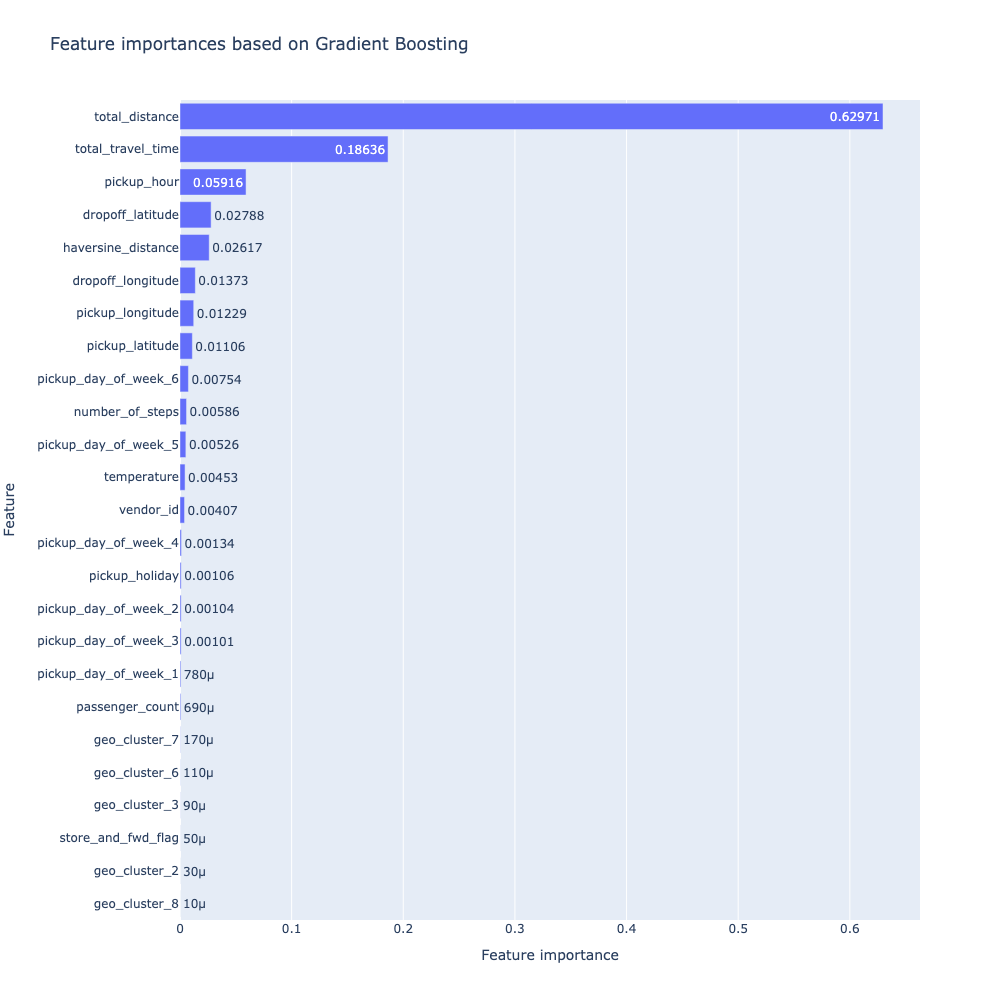

In [292]:
feat_importances = pd.Series(gbr.feature_importances_.round(5), index=X_train.columns)
feat_importances.sort_values(inplace=True)

fig = px.bar(
    feat_importances,
    width=1000,
    height=1000,
    title='Feature importances based on Gradient Boosting',
    orientation='h',
    text_auto=True
).update_layout(
    yaxis_title='Feature',
    xaxis_title='Feature importance',
    showlegend=False
)
fig.show('png')

### Task 6.5.
For the best of the constructed models, calculate the median absolute error (MeAE - in sklearn the function median_absolute_error) of predicting the duration of a taxi ride on the validation sample:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Convert the value of the MeAE metric to minutes and round to tenths.

In [293]:
y_pred_valid_orig = np.exp(y_pred_valid) - 1
y_orig = np.exp(y_valid_log) - 1
meae = (metrics.median_absolute_error(y_orig, y_pred_valid_orig) / 60).round(1)
print('Median absolute error:', meae)

Median absolute error: 1.8


The final step is to submit a prediction on the delayed test dataset.

Let's read the test data and select the column with trip IDs from the test data set in advance. We'll need it later:

In [294]:
test_data = pd.read_csv('../../data/Project5_test_data.csv')
osrm_data_test = pd.read_csv('../../data/Project5_osrm_data_test.csv')
test_id = test_data['id']

Before creating a prediction for the test sample, it is necessary to perform all the manipulations with the data that we performed with the training sample, namely:
* Convert the pickup_datetime feature to datetime format;
* Add new features (time, geographic, weather and other factors);
* Clean the data from gaps;
* Encode categorical features:
* Encode binary features;
* Encode nominal features using OneHotEncoder trained on the training sample;
* Form an observation matrix, leaving in the table only those features that were selected using SelectKBest;
* Normalize the data using MinMaxScaler trained on the training sample.

In [295]:
test_data['pickup_dt'] = pd.to_datetime(test_data['pickup_datetime'])
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

drop_columns = ['id', 'dropoff_datetime', 'pickup_dt', 'pickup_datetime', 'pickup_date']

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

categorical_columns = ['pickup_day_of_week', 'geo_cluster', 'events']
ohe = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')
data_onehot = ohe.fit_transform(test_data[categorical_columns]).toarray()
oh_columns = ohe.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=oh_columns)
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(categorical_columns, axis=1), data_onehot], 
    axis=1
)

X_test = test_data[best_features]
X_test_scaled = mms.transform(X_test)
print('Shape of data:', X_test.shape)

Shape of data: (625134, 25)


Only after completing all these steps can you make a trip duration prediction for the test set. Don't forget to convert the predictions from logarithmic scale to true scale using the formula:
$$y_i=exp(z_i)-1$$

In [296]:
y_pred_test = gbr.predict(X_test_scaled)
y_pred_test = np.exp(y_pred_test) - 1

Once you have generated a trip duration prediction for the test set, you will need to create a submission file in csv format, send it to the Kaggle platform and look at the resulting RMSLE metric value for the test set.

Code for creating a submission file:

In [297]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_pred_test})
submission.to_csv('../../data/Project5_submission_gb.csv', index=False)

### **As a bonus**

In conclusion to the ensemble, we suggest you try to improve your prediction using the extreme gradient boosting (XGBoost) model from the xgboost library.

**XGBoost** is a modern machine learning model that is a continuation of the idea of ​​Friedman's gradient boosting. It has several advantages over the classic gradient boosting model from the sklearn library: increased performance due to parallelization of the training process, increased solution quality due to the improvement of the boosting algorithm, less tendency to overfitting and a wide functionality of the ability to control the model parameters.

To use it, you first need to install the xgboost package:

#!pip install xgboost

After which the module can be imported:

In [298]:
import xgboost as xgb

Before training the model, the datasets need to be converted to the xgboost.DMatrix data type:

In [299]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

The XGBoost model is trained using the train method, which requires passing the model parameters, the dataset, the number of base models in the ensemble, and additional parameters:

In [300]:
# Model hyperparameters
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Training and validation set
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Train the XGBoost model
model = xgb.train(
    params=xgb_pars, # model hyperparameters
    dtrain=dtrain, # training sample
    num_boost_round=300, # number of models in the ensemble
    evals=watchlist, # samples on which the matrix is ​​calculated
    early_stopping_rounds=20, 
    maximize=False, #c hange from maximum to minimum search
    verbose_eval=10 # step through which metrics are displayed
)

[0]	train-rmse:0.74154	valid-rmse:0.74355
[10]	train-rmse:0.49215	valid-rmse:0.49475
[20]	train-rmse:0.44035	valid-rmse:0.44317
[30]	train-rmse:0.42608	valid-rmse:0.42915
[40]	train-rmse:0.41906	valid-rmse:0.42236
[50]	train-rmse:0.41343	valid-rmse:0.41697
[60]	train-rmse:0.40931	valid-rmse:0.41320
[70]	train-rmse:0.40667	valid-rmse:0.41090
[80]	train-rmse:0.40405	valid-rmse:0.40858
[90]	train-rmse:0.40212	valid-rmse:0.40689
[100]	train-rmse:0.40069	valid-rmse:0.40583
[110]	train-rmse:0.39902	valid-rmse:0.40437
[120]	train-rmse:0.39749	valid-rmse:0.40314
[130]	train-rmse:0.39635	valid-rmse:0.40235
[140]	train-rmse:0.39562	valid-rmse:0.40185
[150]	train-rmse:0.39444	valid-rmse:0.40087
[160]	train-rmse:0.39308	valid-rmse:0.39980
[170]	train-rmse:0.39220	valid-rmse:0.39909
[180]	train-rmse:0.39140	valid-rmse:0.39856
[190]	train-rmse:0.39063	valid-rmse:0.39817
[200]	train-rmse:0.38971	valid-rmse:0.39762
[210]	train-rmse:0.38892	valid-rmse:0.39705
[220]	train-rmse:0.38816	valid-rmse:0.39657

You can predict the target feature on new data using the predict() method:

In [301]:
#Making a prediction on a test dataset
y_test_predict = np.exp(model.predict(dtest)) - 1
print('RMSLE on test samples:', round(model.best_score, 5))

RMSLE on test samples: 0.39424


Like all models based on decision trees as base models, XGBoost has the ability to determine the coefficients of factor importance. Moreover, the library has a built-in ability to visualize the importance of factors in the form of a bar chart. The plot_importance() function is responsible for this ability:

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

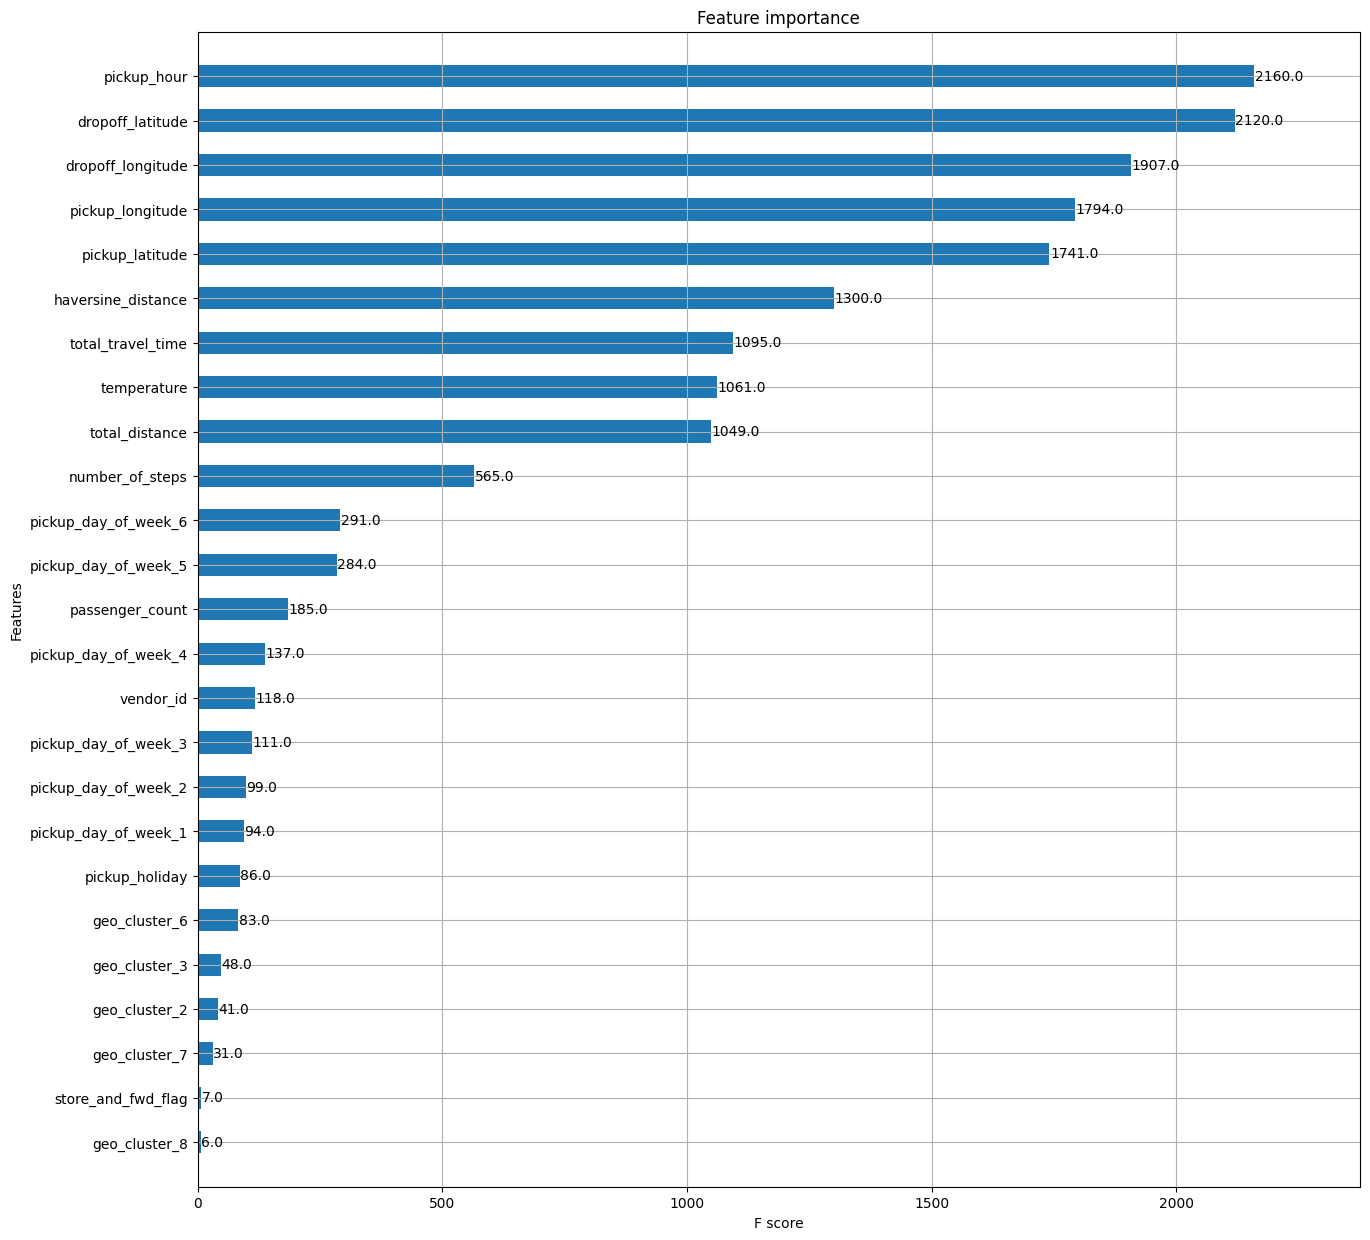

In [302]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)